In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection

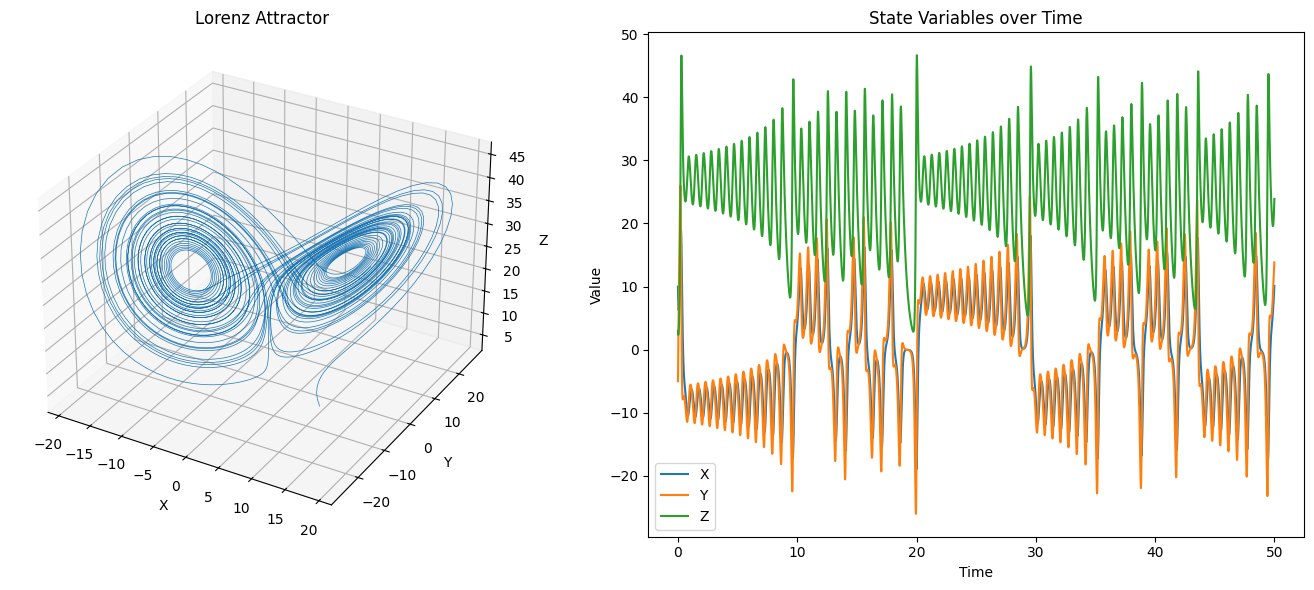

In [46]:


# Singleton class for parameters.
class Parameters:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super(Parameters, cls).__new__(cls)
        return cls._instance

    def __init__(self):
        # Simulation parameters
        self.dt = 0.01      # time step
        self.t_0 = 0.0       # initial time
        self.t_final = 50.0  # final time

        # Lorenz attractor parameters
        self.sigma = 10.0
        self.rho = 28.0
        self.beta = 8.0 / 3.0


class AlgebraicRelationships:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if cls._instance is None:
            cls._instance = super(Parameters, cls).__new__(cls)
        return cls._instance
    
    def __init__(self):

        self.variables = {}

# Base class for any state in your dynamical system.
class State:
    def __init__(self, name, initial_conditions, system=None):
        self.name = name
        # Store the initial condition as a numpy array.
        self.ic = np.array(initial_conditions, dtype=float)
        self.values = [self.ic.copy()]
        self.system = system
        # Automatically register this state with the system if provided.
        if self.system is not None:
            self.system.add_state(self)

    def update(self, new_value):
        """Append a new value to the history."""
        # Use copy to avoid mutable aliasing issues.
        self.values.append(new_value.copy())

    @property
    def current_value(self):
        """Return the most recent state value."""
        return self.values[-1]

    def derivative(self, state_dict):
        """
        Compute the derivative of the state.
        The input state_dict is a dictionary with current (or intermediate)
        values for all states.
        Subclasses must implement this method.
        """
        raise NotImplementedError("Subclasses must implement the derivative method.")

# State classes for each variable in the Lorenz system.
class XState(State):
    def __init__(self, initial_conditions, system=None):
        super().__init__('X', initial_conditions, system)

    def derivative(self, state_dict):
        # dx/dt = sigma*(y - x)
        p = Parameters()
        x = state_dict['X']
        y = state_dict['Y']
        return p.sigma * (y - x)

class YState(State):
    def __init__(self, initial_conditions, system=None):
        super().__init__('Y', initial_conditions, system)

    def derivative(self, state_dict):
        # dy/dt = x*(rho - z) - y
        p = Parameters()
        x = state_dict['X']
        y = state_dict['Y']
        z = state_dict['Z']
        return x * (p.rho - z) - y

class ZState(State):
    def __init__(self, initial_conditions, system=None):
        super().__init__('Z', initial_conditions, system)

    def derivative(self, state_dict):
        # dz/dt = x*y - beta*z
        p = Parameters()
        x = state_dict['X']
        y = state_dict['Y']
        z = state_dict['Z']
        return x * y - p.beta * z

# Mediator class holding all states and integrating the system.
class DynamicalSystem:
    def __init__(self):
        self.states = {}
        self.algebraic_relations = {}

    def add_state(self, state):
        self.states[state.name] = state

    def get_current_state(self):
        """
        Returns a dictionary with the current values of all states.
        Each entry maps the state's name to its current value.
        """
        return {name: state.current_value for name, state in self.states.items()}

    def step(self, dt):
        """
        Update all states for a time step dt using RK4 integration.
        This method calculates the RK4 slopes (k1, k2, k3, k4) for each state
        and then updates all states simultaneously.
        """
        # --- RK4 Step ---
        # k1: use current state values.
        current_state = self.get_current_state()
        k1 = {name: state.derivative(current_state) for name, state in self.states.items()}

        # k2: estimate at t + dt/2 using k1.
        state_half1 = {name: current_state[name] + (dt / 2) * k1[name]
                       for name in current_state}
        k2 = {name: state.derivative(state_half1) for name, state in self.states.items()}

        # k3: another estimate at t + dt/2 using k2.
        state_half2 = {name: current_state[name] + (dt / 2) * k2[name]
                       for name in current_state}
        k3 = {name: state.derivative(state_half2) for name, state in self.states.items()}

        # k4: estimate at t + dt using k3.
        state_full = {name: current_state[name] + dt * k3[name]
                      for name in current_state}
        k4 = {name: state.derivative(state_full) for name, state in self.states.items()}

        # Combine the slopes to compute the new state.
        new_state = {}
        for name in current_state:
            new_state[name] = current_state[name] + (dt / 6) * (
                k1[name] + 2 * k2[name] + 2 * k3[name] + k4[name]
            )

        # Update all states.
        for name, state in self.states.items():
            state.update(new_state[name])

    def get_state_history(self, name):
        """Retrieve the full history for a given state."""
        return [val[0] for val in self.states[name].values]



class Visualizer:
    
    def __init__(self,system):
        self.system = system
        p = Parameters()
        self.t_hist = np.linspace(p.t_0, p.t_final, len(x_hist))

    def plot_variables(variables):

        fig = plt.figure(figsize=(14, 6))
        for i in range(len(variables)):
            y_array = system.get_state_history(variables[i])
            


if __name__ == '__main__':
    # Create a dynamical system.
    system = DynamicalSystem()

    # Create the three states with initial conditions.
    # You can adjust these initial conditions as desired.
    x_state = XState(initial_conditions=[10.0], system=system)
    y_state = YState(initial_conditions=[-5], system=system)
    z_state = ZState(initial_conditions=[3], system=system)

    # Retrieve simulation parameters.
    params = Parameters()
    dt = params.dt
    num_steps = int((params.t_final - params.t_0) / dt)

    # Integrate the system using RK4.
    for _ in range(num_steps):
        system.step(dt)

    # Retrieve full histories for each state.
    # Since each state's value is stored as a numpy array with one element,
    # we extract the scalar value.
    x_hist = system.get_state_history('X')
    y_hist = system.get_state_history('Y')
    z_hist = system.get_state_history('Z')
    t_hist = np.linspace(params.t_0, params.t_final, len(x_hist))

    # Plotting the Lorenz attractor in 3D.
    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot(x_hist, y_hist, z_hist, lw=0.5)
    ax1.set_title("Lorenz Attractor")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")

    # Plotting x, y, and z as a function of time.
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(t_hist, x_hist, label='X')
    ax2.plot(t_hist, y_hist, label='Y')
    ax2.plot(t_hist, z_hist, label='Z')
    ax2.set_title("State Variables over Time")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Value")
    ax2.legend()

    plt.tight_layout()
    plt.show()
